## Import libraries

In [277]:
!pip install matplotlib

In [278]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

import pandas as pd
import re
from nltk.corpus import stopwords

import syft as sy
print(torch.cuda.is_available())

True


In [279]:
STOPWORDS = set(stopwords.words('indonesian'))
# print(f"STOPWORDS:\n {STOPWORDS}")

def clean_text(text):
#     print(f"\n\nOriginal Text: {text}")
    text = text.lower()
#     print(f"\nCase Lowered Text: {text}")
    text = re.sub(r'[^a-z\s]', '', text)
#     print(f"\nRegexed Text: {text}")
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
#     print(f"\nStopwords Removed Text: {text}")
    return text

def tokenize(text, word_to_idx):
    tokens = []
    for word in text.split():
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(0)
    return tokens

def pad_and_truncate(messages, max_length=30):
    features = np.zeros((len(messages), max_length), dtype=int)
#     pprint(f"Messages: {messages}\nFeatures: {features}")
    for i, sms in enumerate(messages):
#         print(f"\ni: {i}\nSMS:{sms}")
        if len(sms):
            features[i, -len(sms):] = sms[:max_length]
    return features


if __name__ == '__main__':
    data = pd.read_csv('dataset_sms_spam_v1.csv', sep=',', names=['Teks', 'Label'])
    data = data.sample(frac = 1)
    #Lowercase, remove unnecessary char with regex, remove stop words
    data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
    words = set((' '.join(data.Teks)).split())
#     print(words)
    word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
    tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
    inputs = pad_and_truncate(tokens)
#     pprint(inputs)
    labels = np.array((data.Label == '1').astype(int))

    np.save('labels.npy', labels)
    np.save('inputs.npy', inputs)

## Loading data

In [280]:
inputs = np.load('inputs.npy')
labels = np.load('labels.npy')

In [281]:
VOCAB_SIZE = int(inputs.max()) + 1

## Training model with Federated learning

### Training and model hyperparameters

In [282]:
# Training params
EPOCHS = 15
CLIP = 5 # gradient clipping - to avoid gradient explosion (frequent in RNNs)
lr = 0.1
BATCH_SIZE = 32

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Initiating virtual workers with Pysyft

In [283]:
labels = torch.tensor(labels)
inputs = torch.tensor(inputs)

# splitting training and test data
# 20% of the data will be for Tests.
pct_test = 0.2

#20% of total data
pct_test_count = -int(len(labels)*pct_test)

# Get 80% of Train LABELS from left.
train_labels = labels[:pct_test_count]
print(f"Train Labels: [:{pct_test_count}]")

# Get 80% of Train INPUTS from left.
train_inputs = inputs[:pct_test_count]
print(f"Train Inputs: [:{pct_test_count}]")

# Get the rest of the LABEL data for test on the right (20%) 
test_labels = labels[pct_test_count:]
print(f"Test Labels: [{pct_test_count}:]")

# Get the rest of the INPUT data for test on the right (20%)
test_inputs = inputs[pct_test_count:]
print(f"Test Inputs: [{pct_test_count}:]")

print(f"Length Labels: {len(labels)}")
print(f"20% of Length Labels: {len(labels)*pct_test}")

Train Labels: [:-228]
Train Inputs: [:-228]
Test Labels: [-228:]
Test Inputs: [-228:]
Length Labels: 1144
20% of Length Labels: 228.8


In [284]:
# Hook that extends the Pytorch library to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(torch)

# Creating 2 virtual workers
bob = sy.VirtualWorker(hook, id="bob")
anne = sy.VirtualWorker(hook, id="anne")

# threshold indexes for dataset split (one half for Bob, other half for Anne)
train_idx = int(len(train_labels)/2)
test_idx = int(len(test_labels)/2)

# Sending toy datasets to virtual workers
bob_train_dataset = sy.BaseDataset(train_inputs[:train_idx], train_labels[:train_idx]).send(bob)
anne_train_dataset = sy.BaseDataset(train_inputs[train_idx:], train_labels[train_idx:]).send(anne)
bob_test_dataset = sy.BaseDataset(test_inputs[:test_idx], test_labels[:test_idx]).send(bob)
anne_test_dataset = sy.BaseDataset(test_inputs[test_idx:], test_labels[test_idx:]).send(anne)

# Creating federated datasets, an extension of Pytorch TensorDataset class
federated_train_dataset = sy.FederatedDataset([bob_train_dataset, anne_train_dataset])
federated_test_dataset = sy.FederatedDataset([bob_test_dataset, anne_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [285]:
from handcrafted_GRU import GRU

In [286]:
# Initiating the model
model = GRU(vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)

### Training

For now, PySyft does not support optimizers with momentum. Therefore, we are going to stick with the classical [Stochastic Gradient Descent](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer.

As our task consists of a binary classification, we are going to use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

In [287]:
# Defining loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

For each epoch we are going to compute the training and validations losses, as well as the [Area Under the ROC Curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) score due to the fact that the target dataset is unbalaced (only 13% of labels are positive).

In [ ]:
train_losses = []
test_losses = []
for e in range(EPOCHS):
    
    ######### Training ##########
    
    losses = []
    # Batch loop
    for inputs, labels in federated_train_loader:
        # Location of current batch
        worker = inputs.location
        # Initialize hidden state and send it to worker
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
        # Send model to current worker
        model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = model(inputs.to(torch.long), h)
        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # Clipping the gradient to avoid explosion
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        model.get()
        losses.append(loss.get())
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in federated_test_loader:
            # get current location
            worker = inputs.location
            # Initialize hidden state and send it to worker
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)    
            # Send model to worker
            model.send(worker)

            output, _ = model(inputs.to(torch.long), h)
            loss = criterion(output.squeeze(), labels.float())
            eval_losses.append(loss.get())
            preds = output.squeeze().get()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.get().numpy().astype(int))
            # Get the model back to the local worker
            model.get()

    #Check test preds
    pprint(f"TEST PREDS: {test_preds[0]}   TEST LABELS LIST: {test_labels_list[0]}")
    score = roc_auc_score(test_labels_list, test_preds)

    train_loss = sum(losses)/len(losses)
    eval_loss = sum(eval_losses)/len(eval_losses)
    train_losses.append(train_loss.item())
    test_losses.append(eval_loss.item())
    
    print("Epoch {}/{}...  \
    AUC: {:.3%}...  \
    Training loss: {:.5f}...  \
    Validation loss: {:.5f}".format(e+1, EPOCHS, score, train_loss, eval_loss))
    
    model.train()

'TEST PREDS: 0.41867971420288086   TEST LABELS LIST: 0'
Epoch 1/15...      AUC: 53.971%...      Training loss: 0.67248...      Validation loss: 0.64164
'TEST PREDS: 0.33084583282470703   TEST LABELS LIST: 0'
Epoch 2/15...      AUC: 58.360%...      Training loss: 0.59223...      Validation loss: 0.62717
'TEST PREDS: 0.4604192078113556   TEST LABELS LIST: 0'
Epoch 3/15...      AUC: 62.562%...      Training loss: 0.57268...      Validation loss: 0.61095
'TEST PREDS: 0.4242745041847229   TEST LABELS LIST: 0'
Epoch 4/15...      AUC: 65.349%...      Training loss: 0.54566...      Validation loss: 0.59848
'TEST PREDS: 0.47984179854393005   TEST LABELS LIST: 1'
Epoch 5/15...      AUC: 68.287%...      Training loss: 0.53188...      Validation loss: 0.59592
'TEST PREDS: 0.08931553363800049   TEST LABELS LIST: 0'
Epoch 6/15...      AUC: 70.219%...      Training loss: 0.50605...      Validation loss: 0.56520


### Plot Losses

Train Losses: [0.6914631724357605, 0.6322644352912903, 0.608394980430603, 0.5939294695854187, 0.5922083258628845, 0.5801754593849182, 0.5588728785514832, 0.5418279767036438, 0.5165913105010986, 0.5054436922073364, 0.48096799850463867, 0.4372141659259796, 0.41798967123031616, 0.39870181679725647, 0.3661279082298279]


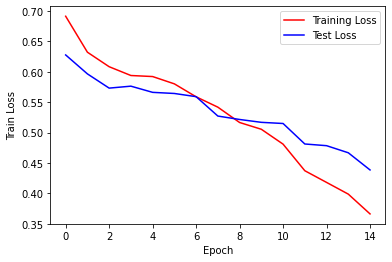

In [23]:
print(f"Train Losses: {train_losses}")
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Saving model for inference

In [24]:
# Save
PATH = "state_dict_model.pt"
torch.save(model.state_dict(), PATH)

GRU(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(4174, 50)
  (gru_cell): GRUCell(
    (fc_ir): Linear(in_features=50, out_features=10, bias=True)
    (fc_hr): Linear(in_features=10, out_features=10, bias=True)
    (fc_iz): Linear(in_features=50, out_features=10, bias=True)
    (fc_hz): Linear(in_features=10, out_features=10, bias=True)
    (fc_in): Linear(in_features=50, out_features=10, bias=True)
    (fc_hn): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Load Model

In [165]:
PATH = "state_dict_model.pt"
model = GRU(vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
model.load_state_dict(torch.load(PATH))
model.eval()

GRU(
  (dropout): Dropout(p=0.2, inplace=False)
  (embedding): Embedding(4174, 50)
  (gru_cell): GRUCell(
    (fc_ir): Linear(in_features=50, out_features=10, bias=True)
    (fc_hr): Linear(in_features=10, out_features=10, bias=True)
    (fc_iz): Linear(in_features=50, out_features=10, bias=True)
    (fc_hz): Linear(in_features=10, out_features=10, bias=True)
    (fc_in): Linear(in_features=50, out_features=10, bias=True)
    (fc_hn): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Ask for input and pre-process text

In [42]:
# text = "Selamat Anda Mendapatkan 50 JUTA!"
# ctext = clean_text(text)
# print(ctext)
# words = ctext.split()
# print(words)
# words = set((' '.join(words)).split())
# token_holder = []
# tokens = tokenize(text, word_to_idx)
# print(f"Tokens:{tokens}")
# # print(word_to_idx)
# token_holder.append(tokens)
# inference_input = pad_and_truncate(token_holder)
# print(f"\nPadded Inputs: {inference_input}")

selamat juta
['selamat', 'juta']
Tokens:[0, 0, 0, 0, 0]

Padded Inputs: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [164]:
data = pd.read_csv('dataset_sms_spam_v1.csv', sep=',', names=['Teks', 'Label'])
data = data.sample(frac = 1)
# Lowercase, remove unnecessary char with regex, remove stop words
data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
words = set((' '.join(data.Teks)).split())
#     print(words)
word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
inputs = pad_and_truncate(tokens)
#     pprint(inputs)
labels = np.array((data.Label == '1').astype(int))

np.save('test_labels.npy', labels)
np.save('test_inputs.npy', inputs)

test_inputs = torch.tensor(np.load('test_inputs.npy'))
test_labels = torch.tensor(np.load('test_labels.npy'))

In [208]:
from torch.utils.data import DataLoader, TensorDataset

In [274]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for inputs, labels in test_loader:
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))

        output, _ = model(inputs.to(torch.long), h)
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        test_preds += list(preds.numpy())
        test_labels_list += list(labels.numpy().astype(int))


acc_score = roc_auc_score(test_labels_list, test_preds)

# The test predictions are in probability, best method to calculate accuracy?
pprint(f"TEST PREDS: {test_preds[0]}   TEST LABELS LIST: {test_labels_list[0]}")
print(f"ROC Accuracy Score: {acc_score}")
    

'TEST PREDS: 0.37878432869911194   TEST LABELS LIST: 1'
ROC Accuracy Score: 0.5530837776506836


In [114]:
# predict(global_federated_test_loader)